# Bayesian machine learning using Markov Chain Monte Carlo


## Bayesian machine learning
 Usually, the goal of machine learning is to give prediction of an black box function which has a mapping  $\mathbf{X} \rightarrow \mathbf{y}$. However, for Bayesian machine learning (BML), the predicted uncertainty should be provided.
<img src="images/kriging_illustration.svg" title="Kriging illustration" width="45%" align="right">

- Known \
    [-] Input: $\mathbf{X}$ \
    [-] Output: $\mathbf{y}$
    
- Unknown\
    [-] mapping relation $f$

- Typical ML methods\
    [-] fitted $\hat{f}$
 
- Bayesian ML methods\
    [-] fitted $\hat{f}$\
    [-] **predicted uncertainty**

## Difference between DNN and BNNs
- Deep Neural Network(DNN): neural network with deterministic hyper-parameters, such as Fig.(a)
- Bayesian Neural Network (BNN): neural network with probabilistic hyper-parameters like Fig.(b)) or activation Fig.(c)
<img src="images/BNN_schematic.png" title="Schematic of DNN and BNNs" width="80%" align="center">


# Bayesian Inference
To make use of BNN, one should train hyper-parameters based on known data firstly and then predicting unknown points.
- **parameter estimation (training phase)**
 $$p \left ( \boldsymbol{\theta} \mid \mathcal{D} \right ) = 
    \frac{  p \left ( \mathcal{D} \mid \boldsymbol{\theta} \right) p \left( \boldsymbol{\theta} \right) }
    { p \left ( \mathcal{D} \right )} , \,\, p \left ( \mathcal{D} \right ) = \int p \left ( \mathcal{D}, \boldsymbol{\theta} \right ) p \left ( \boldsymbol{\theta} \right ) \mathrm{d} \boldsymbol{\theta}$$ 
 
where $p \left( \boldsymbol{\theta} \right)$ is the prior, $p \left ( \mathcal{D} \mid \boldsymbol{\theta} \right)$ is the likelihood, $ p \left ( \mathcal{D} \right )$ is the **marginal likelihood** or **evidence**, and $ p \left ( \boldsymbol{\theta} \mid \mathcal{D} \right )$ is posterior distribution of parameter $\boldsymbol{\theta}$ 

- **predictive posterior distribution (Prediction for unknown points)**
$$p \left (\boldsymbol{\hat{y}} \mid \boldsymbol{x^\prime}, \mathcal{D} \right )
    = \int p \left ( \boldsymbol{\hat{y}} \mid \boldsymbol{x^\prime}, \boldsymbol{\theta}\right)  p \left ( \boldsymbol{\theta} \mid \mathcal{D} \right ) \mathrm{d} \boldsymbol{\theta}$$

---
[1] Jospin, L. V., Laga, H., Boussaid, F., Buntine, W., & Bennamoun, M. (2022). Hands-on Bayesian neural networks—A tutorial for deep learning users. IEEE Computational Intelligence Magazine, 17(2), 29-48.

# Bayesian Inference methods

Getting a analytical posterior distribution $ p \left ( \boldsymbol{\theta} \mid \mathcal{D} \right )$ is an overwhelming task because of high-dimensional and multi-modal probability integral. Therefore, researchers resorted to numerical techniques such as sampling based approaches and variational inference approaches to get an approximate solution. In this notebook, the sampling approaches will be introduced. 

- **Random walk Metropolis-Hasting algorithm**

- **Hamiltonian Monte Carlo**




## Conception of MCMC methods


- **stage 1** Converge to typical set 
- **stage 2** fast explore the whole typical set 
- **stage 3** continue explore typical set and improve accuracy

<img src="images/mcmc_schematic.svg" title="Schematic of MCMC methods" width="90%" align="center">

## Random walk Metropolis-Hasting algorithm  


<img src="images/random_walk_MH_algorithm.png" title="Schematic of DNN and BNNs" width="80%" align="center">

## One-dimensional case illustration (Random walk MH algorithm)

- **Define Target distribution**

In [1]:
# this is tutorial for HMC from their website
import torch
import torch.distributions as dist
import autograd.numpy as np
import hamiltorch
from autograd import grad as grad
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def target_distribution(x):
    # mixture of two Gaussian
    gaussian1 = dist.Normal(-2, 1)
    gaussian2 = dist.Normal(2, 1)
    return 0.3 * gaussian1.log_prob(x).exp() + 0.7 * gaussian2.log_prob(x).exp()

In [3]:
# Perform Metropolis-Hastings algorithm
num_samples = 2000
burn_in = 10
step_size = 5.0

# Initialize the MCMC state variable
x = torch.tensor(0.0, requires_grad=True)

# Run Metropolis-Hastings to generate samples from the target distribution
samples = []
for i in range(num_samples + burn_in):
    with torch.no_grad():
        # Propose a new sample using random walk Metropolis-Hastings
        proposed_x = x + torch.randn(1) * step_size
        # Compute the acceptance probability
        prop_x = target_distribution(proposed_x)
        prop_curr = target_distribution(x)
        # calculate acceptation rate
        alpha = prop_x / prop_curr
        p_accept = torch.min(torch.tensor(1.0), alpha)

        # Accept or reject the proposal
        if torch.rand(1) < p_accept:
            x = proposed_x

    if i >= burn_in:
        samples.append(x.item())

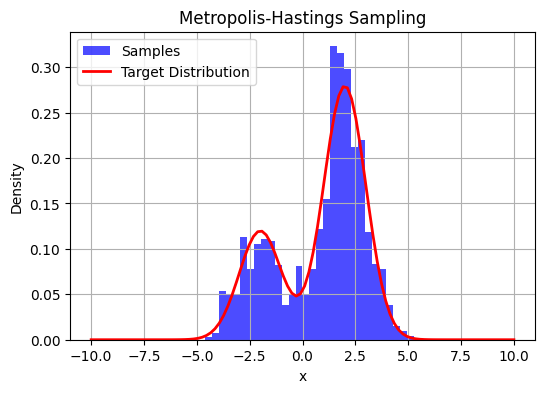

In [4]:
# show the results
# Plot the histogram of the generated samples
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(samples, bins=30, density=True,
        alpha=0.7, color='blue', label='Samples')
x_values = torch.linspace(-10, 10, 100)
ax.plot(x_values, target_distribution(x_values).numpy(),
        color='red', linewidth=2, label='Target Distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings Sampling')
plt.legend()
plt.show()


## Hamiltonian Monte Carlo  
One fatal drawback of Random walk MH algorithm is that the random walk procedure prevents the scalability. To alleviate this issue, the Hamiltonian Monte Carlo is used. The basic of Hamiltonian Monte Carlo will be introduced in this part. 

###  Hamiltonian mechanics

<img src="images/hmc_schematic.png" title="Hamiltonian mechanics" width="50%" align="right">


 $$\mathcal{H}\left(\mathrm{\theta}, \mathrm{v} \right) = 
    \mathcal{\varepsilon(\mathrm{\theta})} + \mathcal{K}(\mathrm{v})$$
where
- set potential energy to QoIs: 

$$\mathcal{\varepsilon(\mathrm{\theta})} = - \log \, \tilde{p}(\mathrm{\theta})$$

- set kinetic energy to be: 
       
$$\mathcal{K}(\mathrm{v}) = \frac{1}{2}\mathrm{v}^{T} {\Sigma}^{-1} \mathrm{v}$$
        
 where ${\Sigma}$ is the mass matrix


Update of parameters within Hamiltonian system:

- **Euler's method** 

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$
\
$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_t)}{\partial \mathrm{v}}$$

- **Modified Euler's method: *Improve accuracy***

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$
\
$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_{t+1})}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+1})}{\partial \mathrm{v}}$$


Update of parameters within Hamiltonian system:
- **Leapfrog method**

$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$
       


### Hamiltonian Monte Carlo 
<img src="images/hmc_algorithm.png" title="Schematic of HMC algorithm" width="70%" align="center">


### Implementation of HMC from scratch 


In [5]:
def hmc(U, grad_U, epsilon, L, current_q):
    q = current_q
    p = np.random.normal(0, 1)  # independent standard normal variates
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # Alternate full steps for position and momentum
    for i in range(L):
        # Make a full step for the position
        q = q + epsilon * p

        # Make a full step for the momentum, except at end of trajectory
        if i != L - 1:
            p = p - epsilon * grad_U(q)
    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = current_p ** 2 / 2
    proposed_U = U(q)
    proposed_K = p ** 2 / 2
    # Accept or reject the state at the end of the trajectory
    if np.random.uniform() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return q  # accept
    else:
        return current_q  # reject

In [6]:
# define target distribution function
def U(q):
    # pdf of target distribution
    obj = 0.3/(np.sqrt(2 * np.pi)) * np.exp(- (q+2)**2 / 2) \
        + 0.7/(np.sqrt(2 * np.pi)) * np.exp(- (q-2)**2 / 2)

    obj = -np.log(obj)

    return obj


def grad_U(q):
    # gradient of U
    return grad(U)(q)


In [7]:
step_size = 0.5  # step size
L = 10  # number of leapfrog
current_q = 0.0  # initial estimation
num_samples = 2000  # number of samples
samples = []
# execute HMC
for _ in range(num_samples):
    current_q = hmc(U, grad_U, step_size, L, current_q)
    samples.append(current_q)


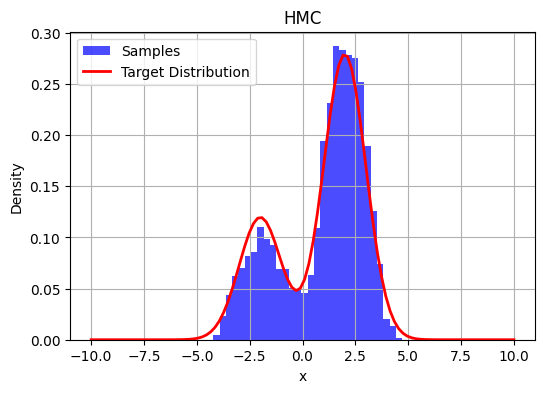

In [8]:
# Plot the histogram of the generated samples
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(samples, bins=30, density=True,
        alpha=0.7, color='blue', label='Samples')
x_values = torch.linspace(-10, 10, 100)
ax.plot(x_values, target_distribution(x_values).numpy(),
        color='red', linewidth=2, label='Target Distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('HMC')
plt.legend()
plt.show()


In [9]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Implementation by hamiltorch [1]

In [10]:
def log_prob_func(params):
    # define the target distribution for sampling
    gaussian1 = dist.Normal(-2, 1)
    gaussian2 = dist.Normal(2, 1)
    obj = torch.log(0.3 * gaussian1.log_prob(params).exp() +
                    0.7 * gaussian2.log_prob(params).exp())
    return obj


In [11]:
params_init = torch.Tensor([1])  # deifne the initial point
params_hmc = hamiltorch.sample(log_prob_func=log_prob_func,
                               params_init=params_init,
                               num_samples=2000,
                               step_size=0.2,
                               num_steps_per_sample=10)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 2000/2000 | 283.85       
Acceptance Rate 1.00


---
[1] https://github.com/AdamCobb/hamiltorch

In [12]:
results = np.zeros((2000, 1))
for ii in range(2000):
    results[ii] = params_hmc[ii][0].numpy()

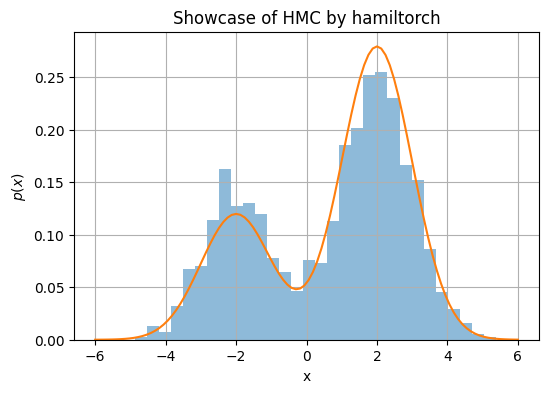

In [13]:
# show the results of HMC by hamiltorch
plt.figure(figsize=(6, 4))
plt.hist(results, alpha=0.5, bins=30, density=True)
plt.plot(np.linspace(-6, 6, 100),
         np.exp(log_prob_func(torch.Tensor(np.linspace(-6, 6, 100)))).numpy())
plt.xlabel('x')
plt.ylabel(r'$p(x)$')
plt.title('Showcase of HMC by hamiltorch')
plt.grid()
plt.show()


## How to sample the posterior of BNN model 


<img src="images/bnn_architecture.svg" title="Schematic of HMC algorithm" width="40%" align="right">

- **BNN Architecture** 

- **Prior** 

$$p(w) \sim \mathcal{N} (0, 1)$$

- **likelihood** 

$$p(D|w)  \sim \mathcal{N} (y, \sigma_a)$$ 

- **posterior distribution**

$$p(w|D) \propto p(D|w)p(w)$$ 



### One-dimensional case illustration 

- **cubic sin function** 

$$f(x) = sin(6x)^3 + \varepsilon, \;\;  \varepsilon \sim \mathcal{N} (0, \sigma^2)$$ 


In [14]:
def cubic_sin(x: torch.Tensor, noise_std: float = 0.05) -> torch.Tensor:
    """cubic sin function with noise"""
    obj = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std
    return obj.reshape((-1, 1))


In [15]:
# generate data
sample_x1 = torch.linspace(-0.8, -0.2, 17).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 17).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
sample_y = cubic_sin(sample_x, noise_std=0.1)

# test data
test_x = torch.linspace(-3, 3, 1000).reshape((-1, 1))
test_y = cubic_sin(test_x, noise_std=0.0)


In [16]:
def plot_cubic_sin():
    plt.figure(figsize=(6, 4))
    plt.plot(sample_x.numpy(), sample_y.numpy(), 'o', label="samples")
    plt.plot(test_x.numpy(), test_y.numpy(), '-',
             label="True function without noise")
    plt.grid()
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


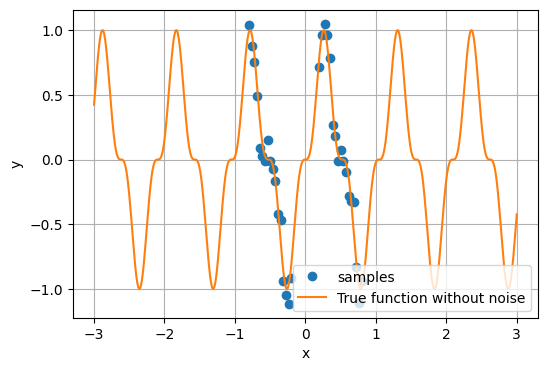

In [17]:
plot_cubic_sin()

**Define BNN architecture**

In [18]:
# define Net architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


**Define hyper-parameters for HMC sampling**


In [19]:
# prepare the for sampling
step_size = 0.002
num_samples = 1000
L = 50
burn = -1
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

tau = 1.0  # Prior Precision, inverse of sigma2
# Output Precision (Likelihood Precision), known noise, inverse of sigma_a**2
tau_out = 100

tau_list = []
for w in net.parameters():
    # set the prior precision to be the same for each set of weights
    tau_list.append(tau)

tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass
print(f'number of parameters: {params_init.shape}')

integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC


number of parameters: torch.Size([141])


**Sampling via HMC to get posterior**

In [20]:
hamiltorch.set_random_seed(1)
params_hmc_f = hamiltorch.sample_model(net, sample_x.to(device), sample_y.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn=burn, inv_mass=inv_mass.to(device), step_size=step_size,
                                       num_steps_per_sample=L, tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler=sampler)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:44 | 0d:00:00:00 | #################### | 1000/1000 | 22.41       
Acceptance Rate 0.97


In [21]:
# get prediction
pred_list, log_probs_f = hamiltorch.predict_model(net, x=test_x.to(device),
                                                  y=test_y.to(device), samples=params_hmc_f,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)


In [22]:
# get the log likehood function value for training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x=sample_x.to(device), y=sample_y.to(device),
                                                            samples=params_hmc_f, model_loss=model_loss,
                                                            tau_out=tau_out, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - sample_y) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * \
        ((pred_list_tr[:i].mean(0).cpu() - sample_y) ** 2).sum(0)


**Plot the log likelihood function value for training data**

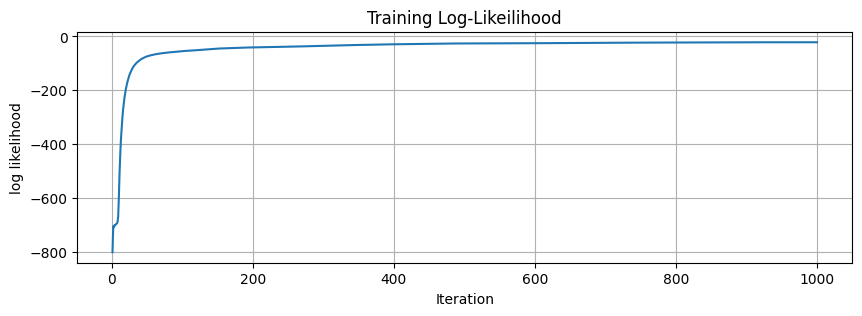

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.set_title('Training Log-Likeilihood')
ax.plot(ll_full)
plt.xlabel("Iteration")
plt.ylabel("log likelihood")
plt.grid()
plt.show()


**plot fitting via HMC**

In [24]:
def plot_fitting():
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.plot(sample_x.numpy(), sample_y.numpy(), 'k*', rasterized=True)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), m.numpy(), 'b', rasterized=True)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.flatten().numpy(), lower.numpy(),
                    upper.numpy(), alpha=0.5, rasterized=True)
    ax.fill_between(test_x.flatten().numpy(), lower_al.numpy(),
                    upper_al.numpy(), alpha=0.2, rasterized=True)
    ax.set_ylim([-3, 3])
    ax.set_xlim([-1.5, 1.5])
    plt.grid()
    ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Total'], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1,
            'boxstyle': 'round', 'edgecolor': 'black'}
    plt.tight_layout()

    plt.show()


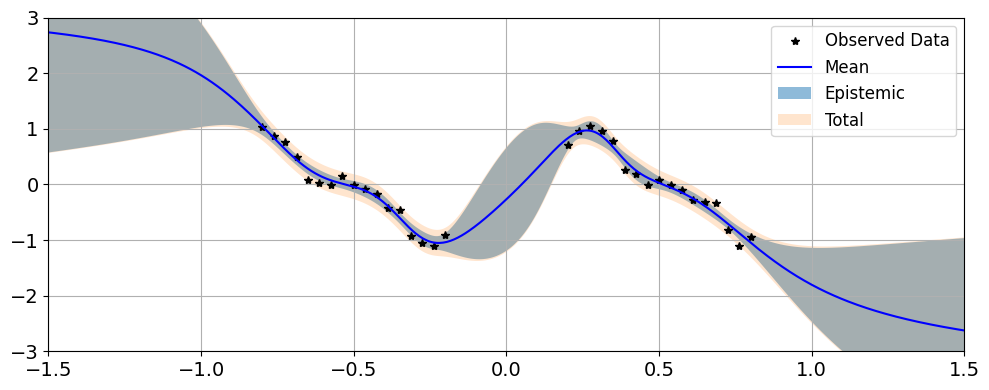

In [25]:
num_burn_in = 100
m = pred_list[num_burn_in:].mean(0).to('cpu')
s = pred_list[num_burn_in:].std(0).to('cpu')
s_al = (pred_list[num_burn_in:].var(0).to('cpu') + tau_out ** -1) ** 0.5

plot_fitting()

## Thanks for your time